<a href="https://colab.research.google.com/github/TharinduGee/Prediction_Models/blob/main/Carbon_Emission_Predictor_Full_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Prediction model of the carbon emmision of vehicle by their model data 
we can use data of US envirionment protecting agency to this project
First we should fetch data from link https://www.epa.gov/system/files/documents/2022-04/22-tstcar-2022-04-15.xlsx

First fetch the data from csv file and drop null columns according to the threshold value given.Then, fill other missing values and devide dataset to the two sets : train, test.


In [1]:
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import tensorflow as tf;

In [2]:
record = pd.read_excel('https://www.epa.gov/system/files/documents/2022-04/22-tstcar-2022-04-15.xlsx');

In [3]:
record = record.dropna(thresh = 3000, axis='columns')
record = record.fillna(method= 'ffill',axis='rows')

In [4]:

train_record = record.sample(frac = 0.8, random_state = 3)
test_record = record.drop(train_record.index)


First after data modification we should examine the fainess of data

Now we should extract the target that want to prredict by model.

In [5]:
train_target = train_record.pop("CO2 (g/mi)")
test_target = test_record.pop("CO2 (g/mi)")


In [6]:
numeric_feature_names = []
categorical_feature_names = []
for name in train_record.columns:
  if record[name].dtype != object:
    numeric_feature_names.append(name)
  else:
    categorical_feature_names.append(name)


In [7]:

inputs = {}

for name, column in train_record.items():
  if type(column[0]) == str:
    dtype = tf.string
  elif (name in categorical_feature_names):
    dtype = tf.int64
  else:
    dtype = tf.float32


  inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)




In [8]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
      values.append(tf.cast(inputs[key], tf.float32))

    return fun(values, axis=-1)


In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(train_record[numeric_feature_names])))

In [10]:
numeric_inputs = {}
preprocessed = []

for name in numeric_feature_names:
  numeric_inputs[name] = inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 27) dtype=float32 (created by layer 'normalization')>]

In [11]:
for name in categorical_feature_names:
  vocab = sorted(set(train_record[name]))
  print(f'name: {name}')
  print(f'vocab: {vocab}\n')

  if type(vocab[0]) is str:
    lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
  else:
    lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

  x = inputs[name][:, tf.newaxis]
  x = lookup(x)
  preprocessed.append(x)

name: Vehicle Manufacturer Name
vocab: ['BMW', 'FCA US LLC', 'FOMOCO', 'Ferrari', 'GM', 'Honda', 'Hyundai', 'Jaguar Land Rover L', 'Karma Automotive, L', 'Kia', 'Lucid USA, Inc', 'MAZDA', 'Maserati', 'McLaren Automotive ', 'Mercedes-Benz', 'Mitsubishi Motors Co', 'Nissan', 'Porsche', 'Rivian Automotive L', 'Rolls-Royce', 'Subaru', 'Tesla', 'Toyota', 'Volkswagen Group of', 'Volvo', 'aston martin']

name: Veh Mfr Code
vocab: ['ASX', 'BMX', 'CRX', 'FEX', 'FJX', 'FMX', 'GMX', 'HNX', 'HYX', 'JLX', 'KAL', 'KMX', 'LMU', 'MAX', 'MBX', 'MLN', 'MTX', 'NSX', 'PRX', 'RIV', 'RRG', 'TKX', 'TSL', 'TYX', 'VGA', 'VVX']

name: Represented Test Veh Make
vocab: ['2022', 'ACURA', 'AUDI', 'Alfa Romeo', 'Aston Martin', 'Audi', 'BENTLEY', 'BMW', 'BMX', 'BUGATTI', 'BUICK', 'Bentley', 'CADILLAC', 'CHEVROLET', 'Chrysler', 'Dodge', 'Ferrari', 'Fiat', 'Ford', 'GMC', 'Genesis', 'HONDA', 'HYUNDAI', 'Honda', 'Hyundai', 'INFINITI', 'Jaguar', 'Jeep', 'KIA', 'Karma', 'Kia', 'LAMBORGHINI', 'LAND ROVER', 'LEXUS', 'Lamborg

In [12]:
preprocessed

[<KerasTensor: shape=(None, 27) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 27) dtype=float32 (created by layer 'string_lookup')>,
 <KerasTensor: shape=(None, 27) dtype=float32 (created by layer 'string_lookup_1')>,
 <KerasTensor: shape=(None, 59) dtype=float32 (created by layer 'string_lookup_2')>,
 <KerasTensor: shape=(None, 779) dtype=float32 (created by layer 'string_lookup_3')>,
 <KerasTensor: shape=(None, 906) dtype=float32 (created by layer 'string_lookup_4')>,
 <KerasTensor: shape=(None, 525) dtype=float32 (created by layer 'string_lookup_5')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'string_lookup_6')>,
 <KerasTensor: shape=(None, 558) dtype=float32 (created by layer 'string_lookup_7')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'string_lookup_8')>,
 <KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'string_lookup_9')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'stri

In [13]:

preprocessed_result = tf.concat(preprocessed,axis=-1)
preprocessed_result

<KerasTensor: shape=(None, 6438) dtype=float32 (created by layer 'tf.concat')>

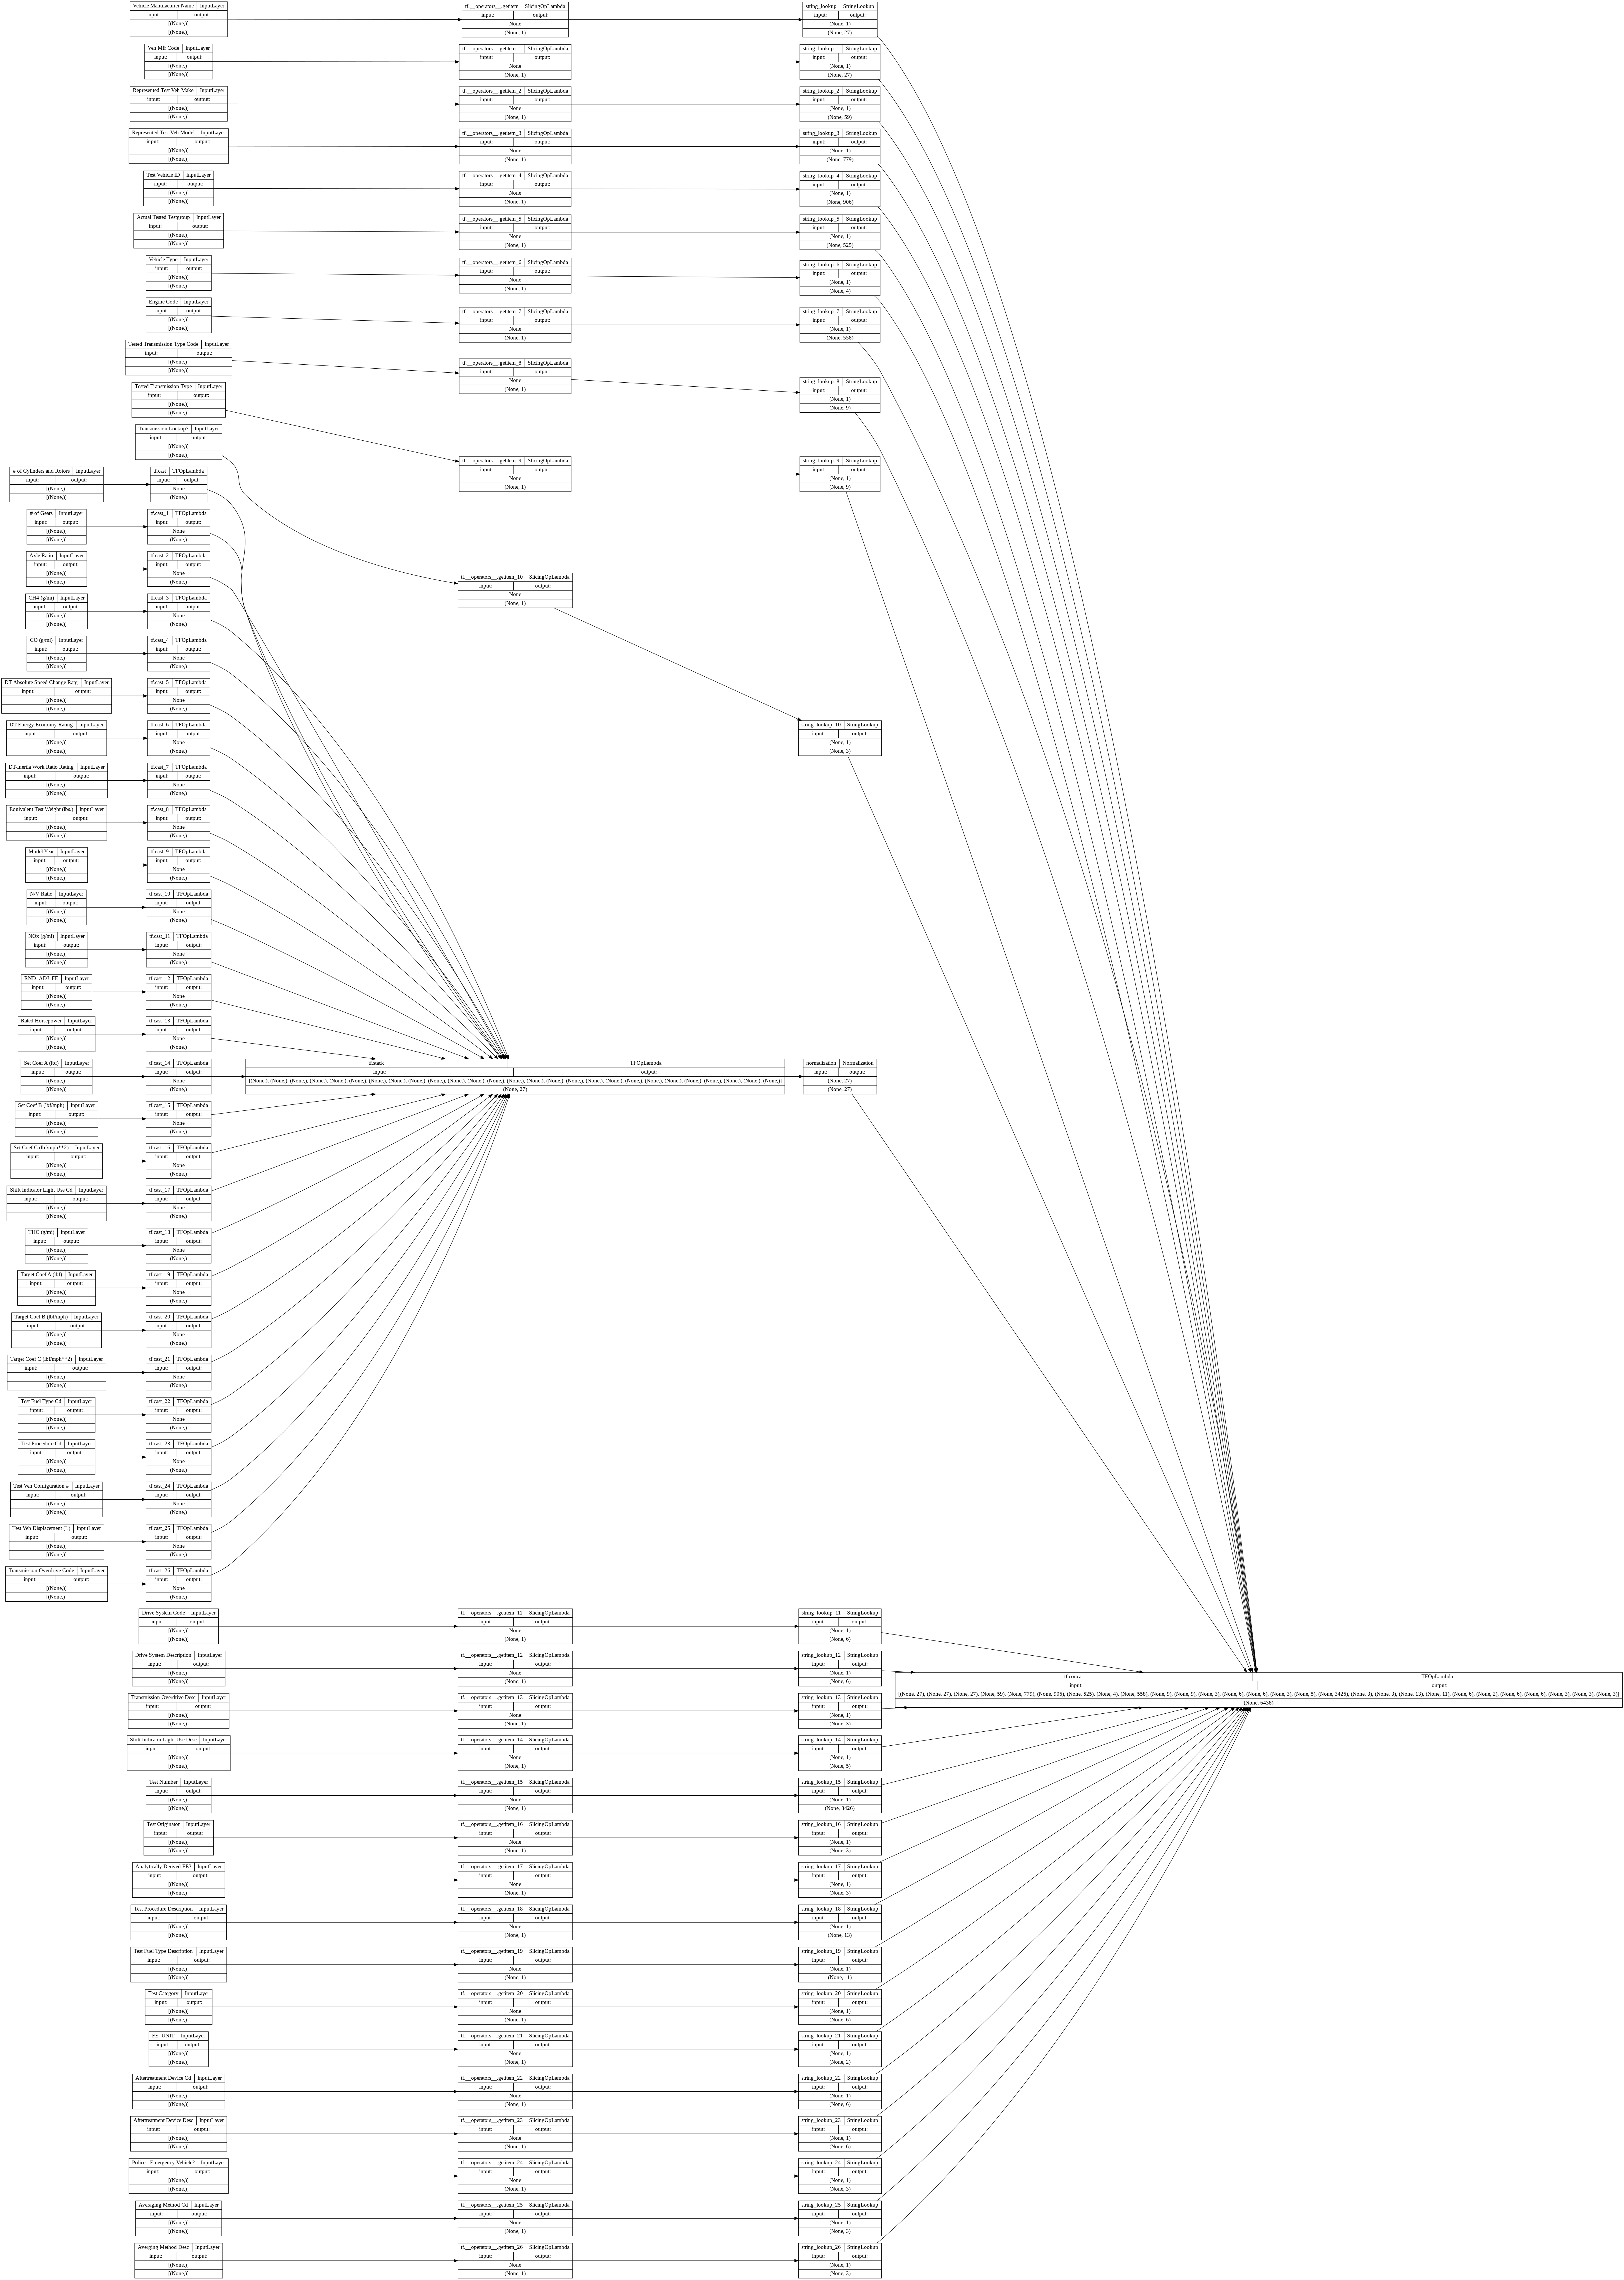

In [14]:
preprocessor = tf.keras.Model(inputs, preprocessed_result)
tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

In [15]:
body = tf.keras.Sequential([
  tf.keras.layers.Dense(124, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.005)),
  
  tf.keras.layers.Dense(1)
])


In [16]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 6438) dtype=float32 (created by layer 'model')>

In [17]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential')>

In [18]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer = tf.keras.optimizers.Adam(0.001),
              loss = 'mean_absolute_error',
              
              )

In [19]:
history =  model.fit(dict(train_record), train_target, validation_split = 0.2, verbose=2, epochs=50, batch_size=20)

Epoch 1/50
141/141 - 7s - loss: 149.5801 - val_loss: 38.8642 - 7s/epoch - 49ms/step
Epoch 2/50
141/141 - 2s - loss: 29.4000 - val_loss: 28.8025 - 2s/epoch - 12ms/step
Epoch 3/50
141/141 - 2s - loss: 21.7751 - val_loss: 24.9721 - 2s/epoch - 12ms/step
Epoch 4/50
141/141 - 2s - loss: 17.4689 - val_loss: 25.1301 - 2s/epoch - 12ms/step
Epoch 5/50
141/141 - 2s - loss: 15.0556 - val_loss: 23.2658 - 2s/epoch - 16ms/step
Epoch 6/50
141/141 - 3s - loss: 13.4509 - val_loss: 22.3417 - 3s/epoch - 21ms/step
Epoch 7/50
141/141 - 3s - loss: 12.2357 - val_loss: 22.4766 - 3s/epoch - 23ms/step
Epoch 8/50
141/141 - 3s - loss: 11.5826 - val_loss: 23.3851 - 3s/epoch - 24ms/step
Epoch 9/50
141/141 - 3s - loss: 10.4943 - val_loss: 20.4818 - 3s/epoch - 23ms/step
Epoch 10/50
141/141 - 3s - loss: 9.0448 - val_loss: 20.4093 - 3s/epoch - 24ms/step
Epoch 11/50
141/141 - 2s - loss: 8.8519 - val_loss: 20.0510 - 2s/epoch - 18ms/step
Epoch 12/50
141/141 - 2s - loss: 8.3257 - val_loss: 20.3447 - 2s/epoch - 12ms/step
Epo

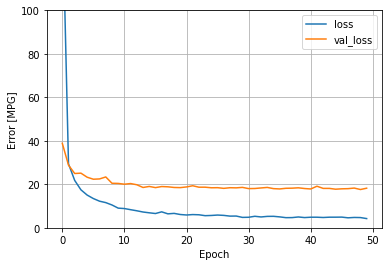

In [20]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Test no 1 : batch_size = 3 , epochs = 30 adam = undefined 132,164,32,1 ,not shuffled
Test no 2 : 

In [21]:
test_results = {}
test_results['test01'] = model.evaluate(dict(test_record), test_target, verbose=0)
pd.DataFrame(test_results, index=['Mean absolute error [CO2 (g/mi)]']).T

,Mean absolute error [CO2 (g/mi)]
test01,17.816984


In [22]:
test_predictions = model.predict(dict(test_record)).flatten()
pd.DataFrame([np.array(test_target),test_predictions,np.array(test_target - test_predictions)],index=['actual','predicted','error']).T

,actual,predicted,error
0,182.937761,192.180496,-9.242735
1,194.365806,206.282501,-11.916695
2,316.657368,279.939362,36.718007
3,259.672000,247.434753,12.237247
4,276.641000,263.161591,13.479409
...,...,...,...
874,230.000000,280.218353,-50.218353
875,223.000000,245.538101,-22.538101
876,342.000000,298.244904,43.755096
877,207.000000,217.824509,-10.824509


for missing co2 values should replace the zero as value ,but should not autofill from another value...